In [ ]:
# KITTI Segmentation Notebook 
## Extracts Semantic Segmentation of image and saves the semantic histograms to a csv format.

In [25]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
import glob
import pandas as pd 
from sklearn.svm import SVC  
import pickle
from matplotlib import gridspec
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from PIL import Image
from collections import namedtuple
import tensorflow as tf
from tensorflow.python.platform import gfile
%matplotlib inline


In [210]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
#   INPUT_SIZE = 1242
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()
    graph_def = None
    
    with gfile.FastGFile(path, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    
#     graph_def = tf.GraphDef.FromString(file.read())

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in path.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    
    return resized_image, seg_map


def create_cityscapes_label_colormap():
  """Creates a label colormap used in CityScapes segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the CityScapes color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_cityscapes_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(3,2,width_ratios=[15,17],height_ratios=[15,15,15])
  grid_spec.update(wspace=0.025)
  plt.subplot(grid_spec[0, :-1])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1,: -1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2, :-1])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[0:, -1])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  ax.set_aspect('equal')

  plt.grid('off')
  plt.savefig('im_seg.png',dpi=300)
  plt.show()


LABEL_NAMES = np.asarray([
    'unlabeled','ego vehicle','rectification border','out of roi','static','dynamic',
    'ground','road','sidewalk','parking','rail track','building','wall','fence','guard rail',
    'bridge','tunnel','pole','polegroup','traffic light','traffic sign','vegetation',
    'terrain','sky','person','rider','car','truck','bus','caravan','trailer','train',
    'motorcycle','bicycle','license plate'
])


# LABEL_NAMES = np.asarray([
#     'ground','road','sidewalk','parking','building','wall','fence',
#     'tunnel','pole','polegroup','traffic light','traffic sign','vegetation',
#     'terrain','sky','person','rider','car','truck','bus','caravan','trailer','train',
#     'motorcycle','bicycle','license plate'
# ])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [211]:
#@title Select and download models {display-mode: "form"}

path="/mnt/storage/home/ja17618/scratch/models/research/deeplab/datasets/fully_trained/deeplabv3_cityscapes_train/frozen_inference_graph.pb"
MODEL = DeepLabModel(path)
print('model loaded successsful')

model loaded successsful


In [169]:
#@title Run on sample images {display-mode: "form"}

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = '/mnt/storage/home/ja17618/scratch/DATA_DIR/training/image_2/007479.png'  #@param {type:"string"}
# IMAGE_URL = "/mnt/storage/home/ja17618/scratch/models/research/deeplab/datasets/cityscapes/leftImg8bit/train/bochum/bochum_000000_000313_leftImg8bit.png"




def convert_train_id_to_eval_id(seg):
  """Converts the predicted label for evaluation.
  There are cases where the training labels are not equal to the evaluation
  labels. This function is used to perform the conversion so that we could
  evaluate the results on the evaluation server.
  Args:
    prediction: Semantic segmentation prediction.
    train_id_to_eval_id: A list mapping from train id to evaluation id.
  Returns:
    Semantic segmentation prediction whose labels have been changed.
  """
  train_id_to_eval_id = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22,
                                   23, 24, 25, 26, 27, 28, 31, 32, 33]
  converted_prediction = seg.copy()
  
  for train_id, eval_id in enumerate(train_id_to_eval_id):
    converted_prediction[seg == train_id] = eval_id

  return converted_prediction

def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(url)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return
#
#   print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)
  return resized_im, seg_map
 


# print(seg)

In [84]:
def preprocess():

    import pandas as pd 

    labels = pd.read_csv("labels.csv",dtype={'frame': np.int32, 'context': np.str} )
    labels["frame"]=labels['frame'].apply(lambda x: '{0:0>6}'.format(x))
    path = "/mnt/storage/home/ja17618/scratch/DATA_DIR/training"
    out="/mnt/storage/home/ja17618/scratch/DATA_DIR/"
    f_lidar = glob.glob(os.path.join(path, 'velodyne', '*.bin'))
    data_tag = [name.split('/')[-1].split('.')[-2] for name in f_lidar]
    type(data_tag[0])    
    labels.loc[labels['context'].str.contains('non', case=False), 'context'] = 0
    labels.loc[labels['context'].str.contains('urban', case=False,na=False), 'context'] = 1
    urban = labels[labels['context']==1]
    urban =urban['frame']
    print(urban)
    non_urban = labels[labels['context']==0]
    non_urban= non_urban['frame']
    print(non_urban)
    urban.to_csv(out+'urban.txt', sep='\n', index=False)
    non_urban.to_csv(out+'non_urban.txt',sep='\n', index=False)
    
# preprocess()

In [6]:
# for t in l["frame"]:
#     print(t)
#     img=mpimg.imread(path+"image_2/"+t+'.png')
#     imgplot = plt.imshow(img)
#     plt.show()
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]
id2catid = {label.id : label.categoryId for label in labels}

In [7]:
urban_path = "/mnt/storage/home/ja17618/scratch/DATA_DIR/context/urban/"
non_urban_path = "/mnt/storage/home/ja17618/scratch/DATA_DIR/context/non_urban/"
urb_rgb = glob.glob(os.path.join(urban_path, 'image_2', '*.png'))
nurb_rgb = glob.glob(os.path.join(non_urban_path, 'image_2', '*.png'))
from timeit import default_timer as timer
label_path ='/mnt/storage/home/ja17618/scratch/models/research/deeplab/datasets/labels.csv'
labels = pd.read_csv(label_path,)
labels['frame']=labels['frame'].apply(lambda x: '{0:0>6}'.format(x))

np.set_printoptions(threshold=np.nan)
def id_label(id):
    return id2label[id].name
def id_cat(id):
    return id2catid[id]



In [8]:
bins = sorted([7, 8, 11, 12, 13, 17, 19, 20, 21, 22,
                                   23, 24, 25, 26, 27, 28, 31, 32, 33])
vals = []
cls = []

In [9]:
frms = []

In [60]:

for image in urb_rgb:
    frame = image[-10:][:6]
    ctx = labels[labels['frame']==frame]
    ctx = ctx['context'].values[0]
    im, seg = run_visualization(image)
    seg1 = convert_train_id_to_eval_id(seg)
    hist, bin_edges = np.histogram(seg1, bins=bins)
    vals.append(hist)
    cls.append(ctx)
    frms.append(frame)
#     print(vals)

#     plt.bar(bin_edges[:-1], hist, width = 1)
#     plt.xlim(min(bin_edges), max(bin_edges))
#     plt.show()   
#     vis_segmentation(im, seg1)
#     input()

    
#     print(im.size, seg.shape)
#     seg2 = seg1.reshape((im.size[0],-1))
#     f = np.vectorize(id_label,otypes=[np.str])
#     seg3 = f(seg1)
    
  
#     print(seg1)
#     hist, bin_edges = np.histogram(seg1, density=True)
#     plt.hist(seg2, bins='auto') 
#     plt.show()
#     input()

KeyboardInterrupt: 

In [11]:
for image in nurb_rgb:
    frame = image[-10:][:6]
    ctx = labels[labels['frame']==frame]
    ctx = ctx['context'].values[0]
    im, seg = run_visualization(image)
    seg1 = convert_train_id_to_eval_id(seg)
    hist, bin_edges = np.histogram(seg1, bins=bins)
    vals.append(hist)
    frms.append(frame)
    cls.append(ctx)

In [29]:
# feat = [id2label[b].name for b in bins]
# print(feat)
y = [np.where(y_t == 'urban', 1, 0) for y_t in cls]

In [21]:
print('done')

ds =[]

for v in vals:
    
    dic = dict(zip(feat,v))
    ds.append(dic)
#     print(dic)
    
cls_df = pd.DataFrame(ds)


done


In [41]:
# filename='/mnt/storage/home/ja17618/workspace/image_context.sav'
# context_model = pickle.load(open(filename, 'rb'))
# context_model.score(vals,y )
# for v in vals:
# #     result =context_model.predict([v])
#     print(result)

In [42]:
# for image in nurb_rgb[:20]:
    

In [22]:
cls_df = cls_df.assign(y=y)

In [23]:
cls_df.to_csv('/mnt/storage/home/ja17618/scratch/seg.csv',index=0)

/mnt/storage/home/ja17618/.conda/envs/vox/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


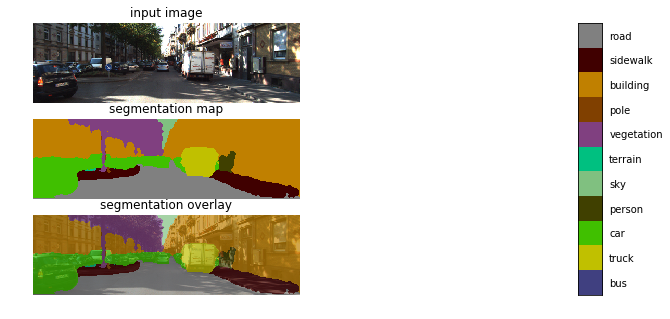

In [212]:
import pylab as pl
from matplotlib import cm
import numpy as np
from scipy import interpolate
from scipy import ndimage

image = urb_rgb[1]
start = timer()
im, seg = run_visualization(image)
end = timer()
seg1 = convert_train_id_to_eval_id(seg)
# print(seg[:20])
# print(seg1[:20])
vis_segmentation(im, seg1)
# print(end-start)
# print(im.size, seg.shape)



# seg2 = seg1.reshape((im.size[0],-1))


# f = np.vectorize(id_label,otypes=[np.str])
# f2 = np.vectorize(id_cat)
# levels = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22,
#                                    23, 24, 25, 26, 27, 28, 31, 32, 33]
# seg3 = f(seg1)
# seg4 = f2(seg1)
# # print(seg4)
# a,b = seg1.shape[0], seg1.shape[1]
# print(a,b)
# y = np.linspace(0,a,a)
# x = np.linspace(0,b,b)
# # print(x,y)
# FR= np.flipud(seg1)
# X, Y = np.mgrid[0:375, 0:1242]
# X, Y = np.meshgrid(x,y)
# fig, axes = pl.subplots(1, 2, figsize=(15, 4))
# c1 = axes[0].contourf(X, Y, FR,levels = levels)
# pl.colorbar(c1, ax=axes[0]);

# tmp = np.repeat(np.repeat(FR, 10, axis=1), 10, axis=0)
# # x, y = np.mgrid[0:3750, 0:12420]
# y = np.linspace(0,a,a*10)
# x = np.linspace(0,b,b*10)
# c2 = axes[1].contourf(x, y, ndimage.gaussian_filter(tmp, 3), levels=c1.levels)
# pl.colorbar(c2, ax=axes[1]);
# # rbf = interpolate.Rbf(X.ravel(), Y.ravel(), FR.ravel(), smooth=0.000001)
# # X2, Y2 = np.mgrid[0:1:375j, 0:1:1242j]
# # c3 = pl.contourf(X2, Y2, rbf(X2, Y2))
# # pl.colorbar(c3, ax=axes[2]);


In [28]:
# len(c2.collections)
# cs = c2
# print(cs.levels)
# from shapely import geometry
# import shapely
# for col,lvl in zip(cs.collections, cs.levels):
#     # Loop through all polygons that have the same intensity level
#     print(lvl)
#     for contour_path in col.get_paths(): 
#         # Create the polygon for this intensity level
#         # The first polygon in the path is the main one, the following ones are "holes"
#         for ncp,cp in enumerate(contour_path.to_polygons()):
#             x = cp[:,0]
#             y = cp[:,1]
#             new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(x,y)])
#             if ncp == 0:
#                 poly = new_shape
#             else:
#                 # Remove the holes if there are any
#                 poly = poly.difference(new_shape)
# #                 Can also be left out if you want to include all rings
#         if isinstance(poly, shapely.geometry.polygon.Polygon):
# #             print('Polygon')
#             fig=plt.figure()
#             x, y = poly.exterior.xy
#             ax = fig.add_subplot(111)
#             ax.plot(x, y, color='#6699cc', alpha=0.7,
#             linewidth=3, solid_capstyle='round', zorder=2)
#             ax.set_title('%s Polygon ' %id_label(lvl))
#             plt.show()
# #         elif isinstance(poly, shapely.geometry.multipolygon.MultiPolygon):
# #             allparts = [p.buffer(0) for p in poly.geometry]
# #             poly.geometry = shapely.ops.cascaded_union(allparts)
# #             x, y = poly.exterior.xy  # here happens the error
        
#         # do something with polygon
# #         print(poly) 